In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/reddit-flair-dataset/reddit_data.csv
/kaggle/input/fasttext-crawl-300d-2m/crawl-300d-2M.vec


Importing all necessary libraries

In [29]:
import pandas as pd
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D, GRU, BatchNormalization
from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, Add, Flatten
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
from keras.models import Model, load_model
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras import backend as K
from keras.engine import InputSpec, Layer
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import plot_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.stem import WordNetLemmatizer
import nltk
import re

Loading the dataset

In [8]:
posts = pd.read_csv('/kaggle/input/reddit-flair-dataset/reddit_data.csv')

In [19]:
posts.head()

Unnamed: 0                                              title  score  \
0           0  Attractive men, what type of attention do you ...     20   
1           1  [askindia] My brothers bank account was hacked...     42   
2           2                     [AskIndia] What song is this ?      5   
3           3  [AskIndia][Serious] Is it worth attempting imm...     55   
4           4  [AskIndia] What are some cheap but reliable an...     21   

       id subreddit                                                url  \
0  cprtaa     india  https://www.reddit.com/r/india/comments/cprtaa...   
1  dacmel     india  https://www.reddit.com/r/india/comments/dacmel...   
2  comakt     india  https://www.reddit.com/r/india/comments/comakt...   
3  c4ilk5     india  https://www.reddit.com/r/india/comments/c4ilk5...   
4  dpmgmj     india  https://www.reddit.com/r/india/comments/dpmgmj...   

   num_comments                                               body  \
0            21  xposted from /r/askmen, posted here because In...   
1            64  My brother received bunch of SMS this morning ...   
2             6  Often when I think of home there is a particul...   
3           115  Title. \n\nFrom what I understand based on arm...   
4            25  I won't play games or edit videos.\n\nI will u...   

        created     flair  
0  1.565725e+09  AskIndia  
1  1.569682e+09  AskIndia  
2  1.565493e+09  AskIndia  
3  1.561382e+09  AskIndia  
4  1.572552e+09  AskIndia

# Part I - Exploratory Data Analysis

In [9]:
posts['flair'].value_counts()

Politics              247
Food                  242
Scheduled             234
Business/Finance      233
AskIndia              232
Sports                231
Photography           222
Science/Technology    221
Policy/Economy        220
Non-Political         216
AMA                   212
Name: flair, dtype: int64

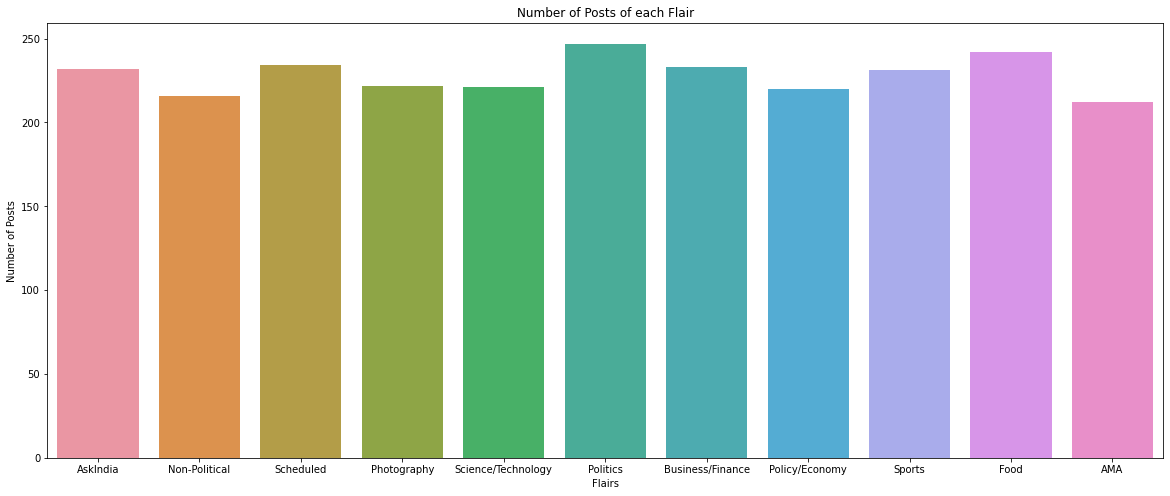

In [10]:
plt.figure(figsize=(20,8))
sns.countplot(x='flair', data=posts)
plt.title("Number of Posts of each Flair")
plt.xlabel('Flairs')
plt.ylabel("Number of Posts")
plt.show()

The data is almost equally distributed<br>



Checking the average number of comments on the posts in the dataset

In [11]:
posts['num_comments'].sum()/posts.shape[0]

60.33904382470119

Making a Histogram to check the Comment Distribution for the posts in the dataset

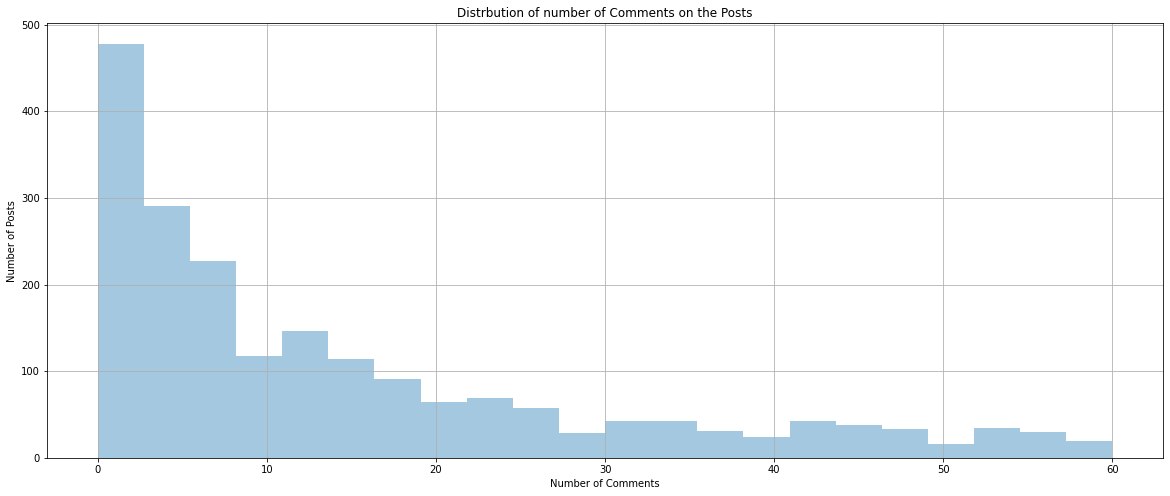

In [12]:
plt.figure(figsize=(20,8))
sns.distplot(posts[posts["num_comments"] < 61]["num_comments"], kde=False)
plt.grid()
plt.title("Distrbution of number of Comments on the Posts")
plt.ylabel("Number of Posts")
plt.xlabel("Number of Comments")

plt.show()

According to the above graph most of the posts are having atmost 10 comments in the dataset

Checking the average number of scores on the posts in the dataset

In [13]:
posts['score'].sum()/posts.shape[0]

147.20239043824702

Making a Histogram to check the Score Distribution for the posts in the dataset

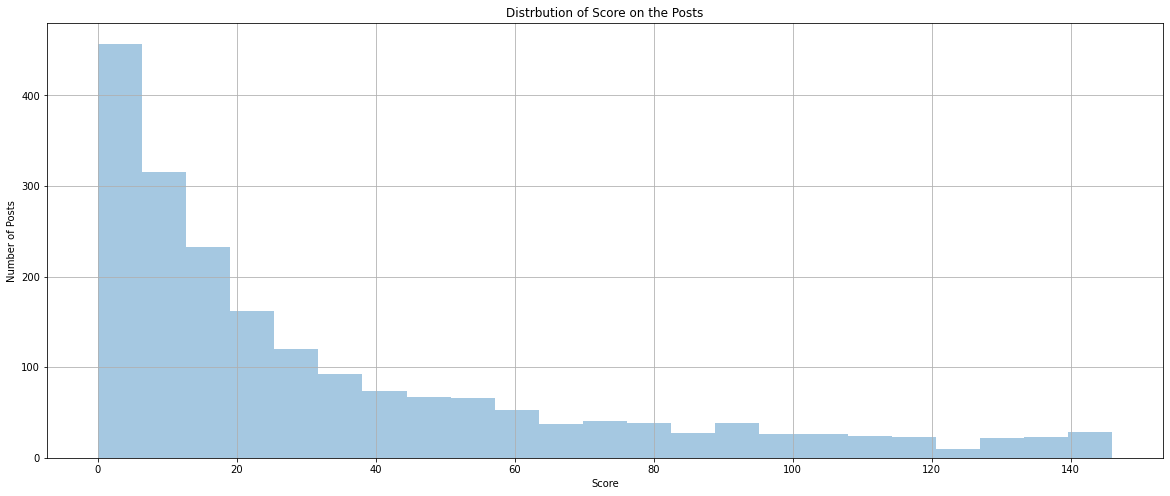

In [14]:
plt.figure(figsize=(20,8))
sns.distplot(posts[posts["score"] < 147]["score"], kde=False)
plt.grid()
plt.title("Distrbution of Score on the Posts")
plt.ylabel("Number of Posts")
plt.xlabel("Score")

plt.show()

It is clearly visible that most of the posts contains atmost 30 score in the dataset.

Showing top 15 posts having highest number of comments

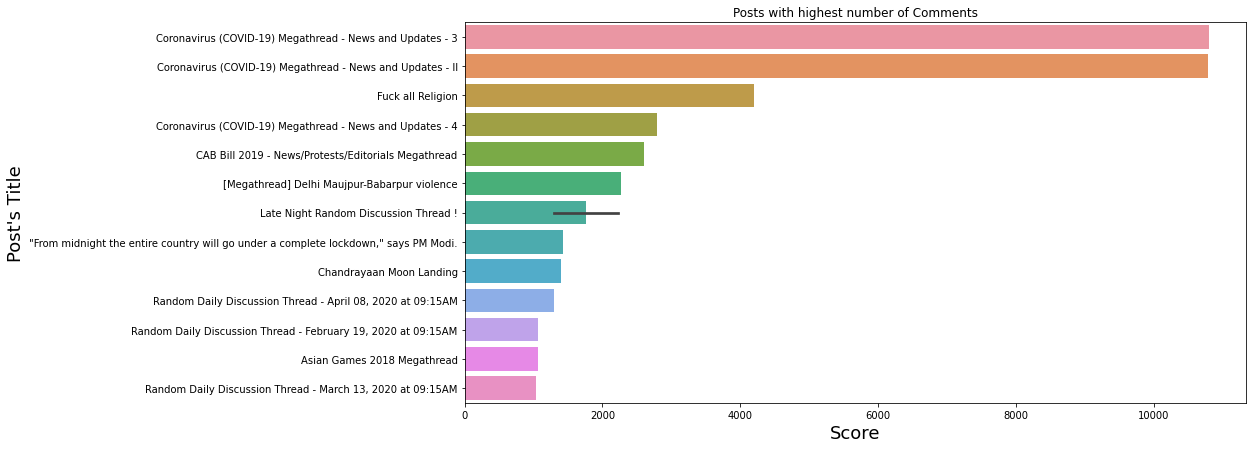

In [15]:
data_score = posts.sort_values('num_comments', ascending=False).head(15)
plt.figure(figsize=(14,7))
plt.title("Posts with highest number of Comments")
sns.barplot(y=data_score['title'],x=data_score['num_comments'])
plt.xlabel('Score',fontsize=18)
plt.ylabel("Post's Title",fontsize=18)
plt.show()

Shwoing top 15 posts having highest score

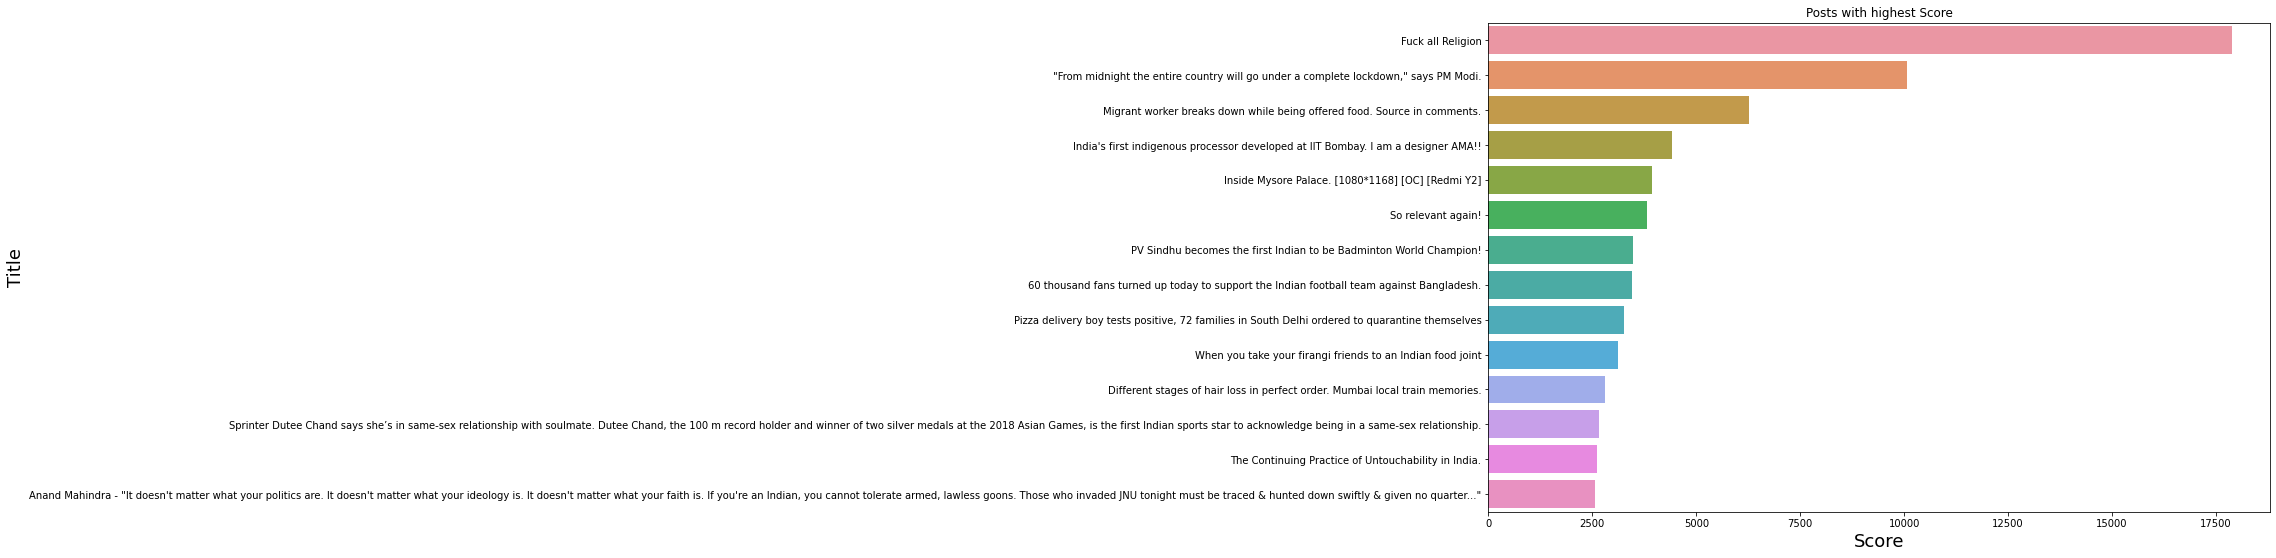

In [16]:
data_score = posts.sort_values('score', ascending=False).head(15)
plt.figure(figsize=(14,9))
plt.title('Posts with highest Score')
sns.barplot(y=data_score['title'],x=data_score['score'])
plt.xlabel('Score',fontsize=18)
plt.ylabel('Title',fontsize=18)
plt.show()

Let's check that more number of Comments results more score or not i.e, does these factors relates each other. For this I'll first find the correlation mactrix of columns than plot a heatmap.

In [17]:
correlation =  posts.corr()
correlation

Unnamed: 0     score  num_comments   created
Unnamed: 0      1.000000  0.069577      0.010690  0.167588
score           0.069577  1.000000      0.354176  0.087227
num_comments    0.010690  0.354176      1.000000  0.024657
created         0.167588  0.087227      0.024657  1.000000

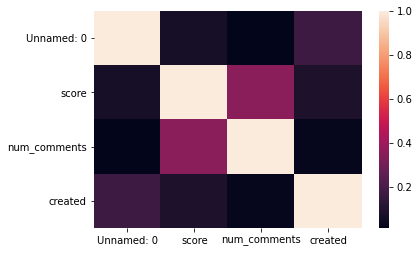

In [18]:
sns.heatmap(correlation)
plt.show()

Here we can see that there is a small positive correlation of 0.3 between score and number of comments. That mean there is a little bit relation between these columns but do not completly dependent upon each other.

Now lets check the most occured words in the title of each flair. I am plotting the wordcloud which shows the mostly occured word with biggest font size and least occured word with smallest font size.

before that lets make a set of stopwords which are not needed to detect the flair of a sentence.

In [20]:
import nltk
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


False

In [21]:
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

Plotting the **Wordclouds** of each flair.

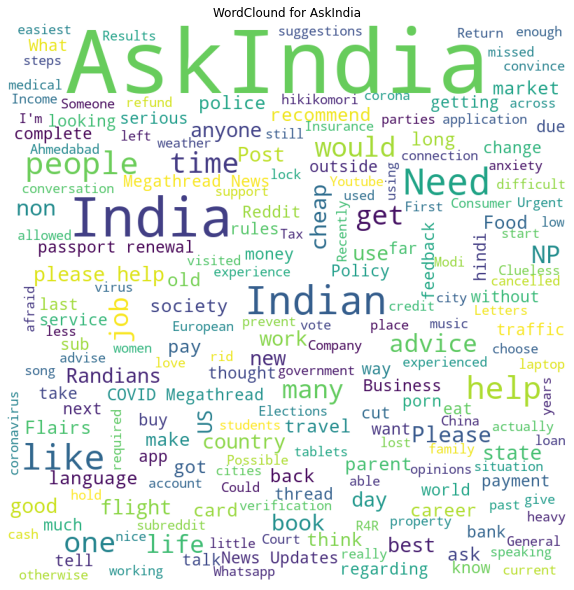

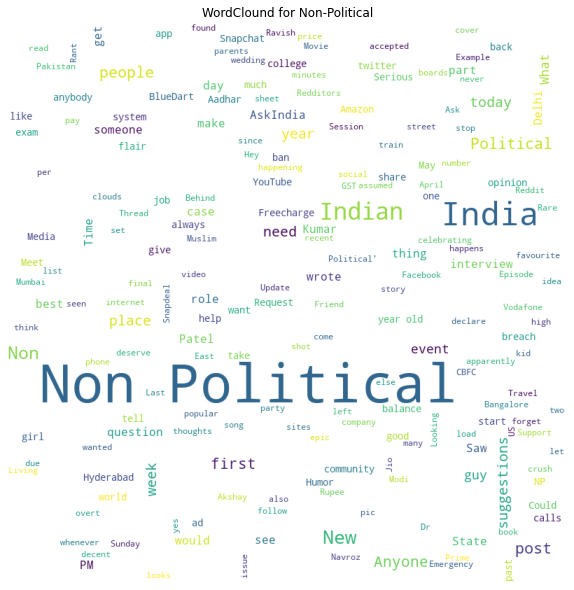

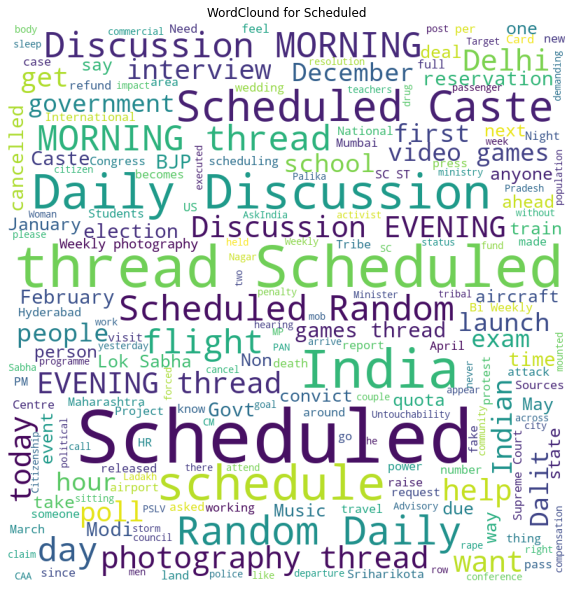

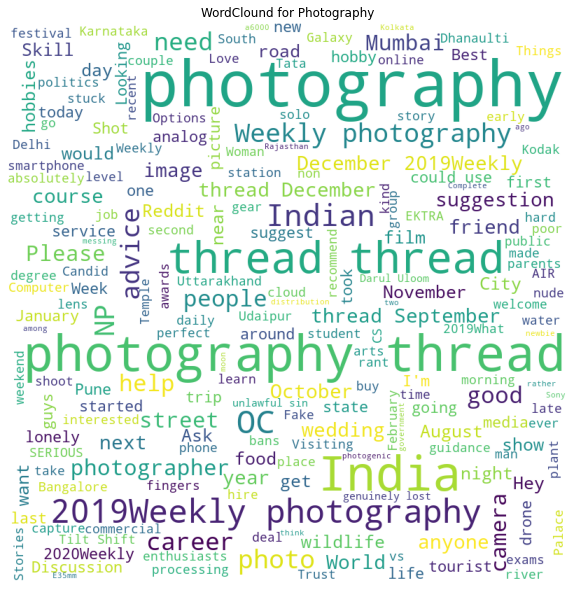

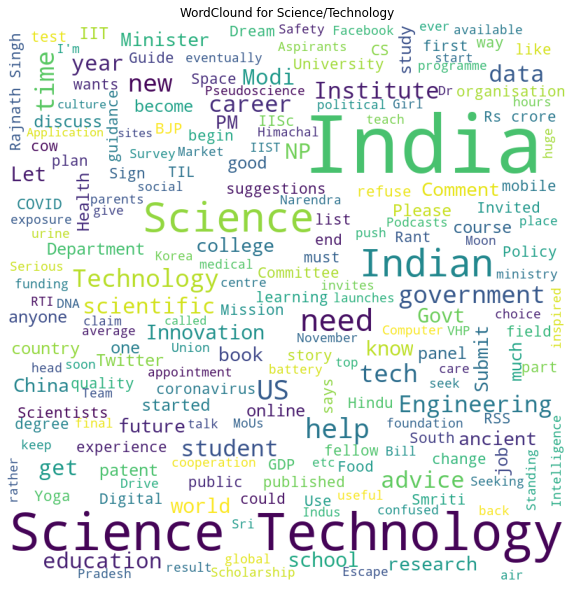

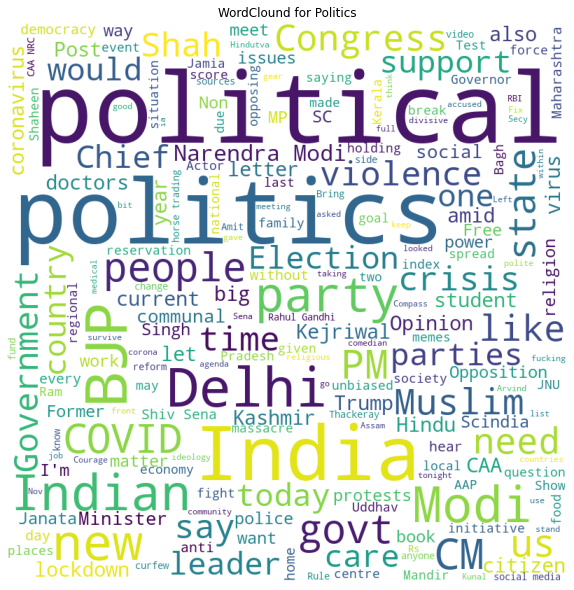

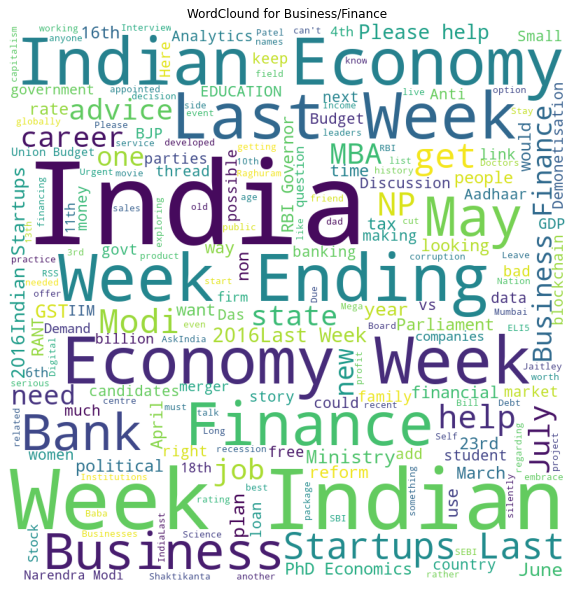

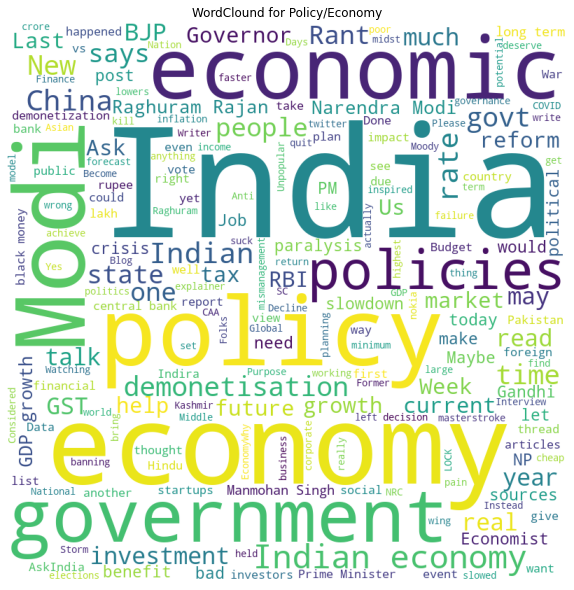

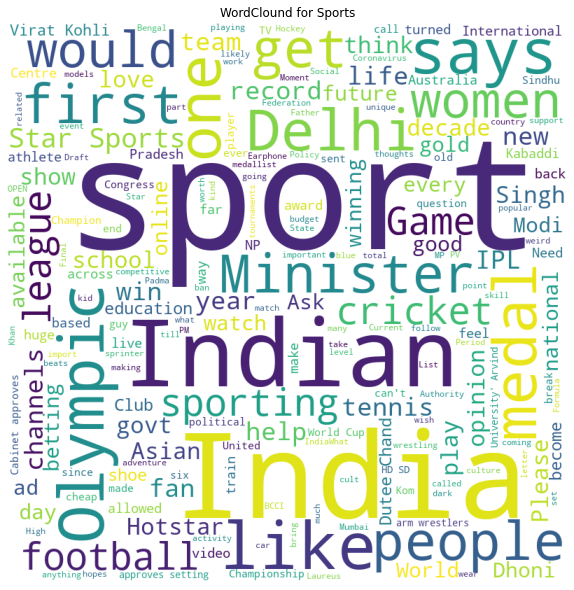

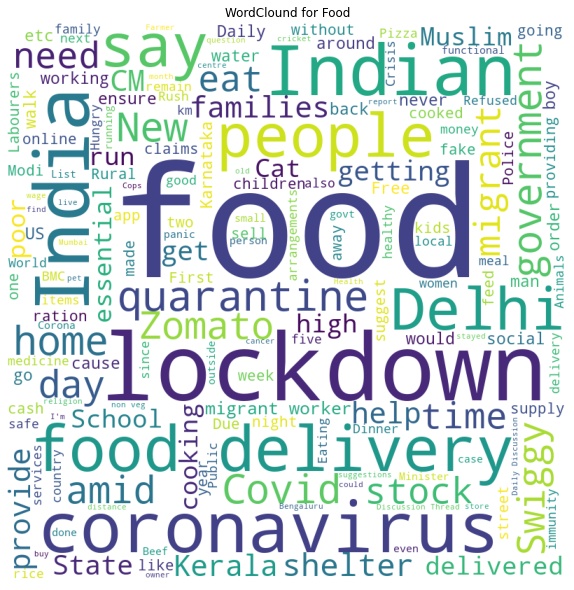

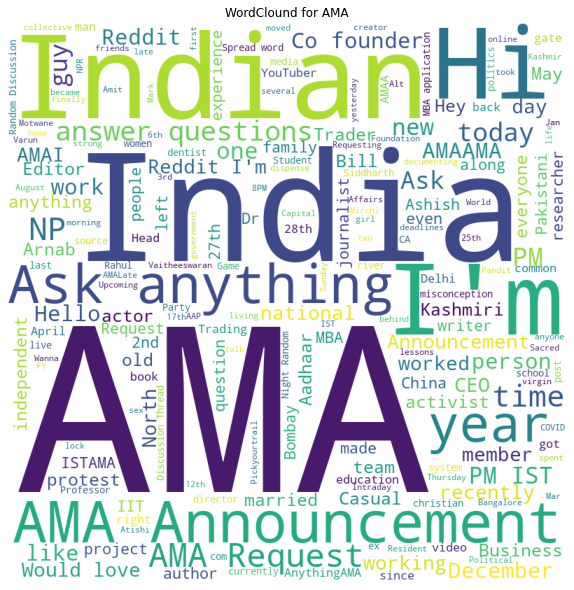

In [23]:
flairs = posts['flair'].unique()
from wordcloud import WordCloud, STOPWORDS 
for flair in flairs:
  content = ""
  for i in posts[posts['flair']==flair]['title']:
    content+=i
  wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stop, min_font_size = 10).generate(content)
  plt.figure(figsize = (8, 8), facecolor = None) 
  plt.imshow(wordcloud) 
  plt.title("WordClound for "+flair)
  plt.axis("off")
  plt.tight_layout(pad = 0) 
  plt.show() 

# Part II - Building a Flare Detector

Before making a Deep Learning model, I have to choose the more relevant words that can be used to classify easily and also I have to convert the text data into vectors so that I can feed the data to the model for training.

I am going to classify the posts by checking the thier titles.

Making a function to remove noise i.e, unwanted data from our dataset. This function is doing following tasks: 
1. Converting each and every word or letter to lower case
2. Removing Extra Whitespaces
3. Removing words inside brackets like [OC], [ASKINDIA] etc.
4. Removing every character which is non alphanumeric.
5. Limmatizing the data.It is the process of grouping together the different inflected forms of a word so they can be analysed as a single item. Such as "good better" becomes "good good".
6. Removing stopwords like "if", "here", "there" etc. which are not needed to classify the sentences.
    By using these steps we can reduce the redundancy and the size of data so that our model get trained on a relevant data.


In [25]:
nltk.download('wordnet')

def remove_noise(text):

    # Step1: Make lowercase
    text = text.apply(lambda x: " ".join(x.lower() for x in x.split()))
    
    # Step2: Remove whitespaces
    text = text.apply(lambda x: " ".join(x.strip() for x in x.split()))

    # Step3 : Removing words inside brackets like "[OC]"
    text = text.apply(lambda x: re.sub(r"\[.*?\]", "", x))

    # Step4 : Removing everything from the data which is not alphanumeric.
    text = text.apply(lambda x: re.sub('[^a-zA-Z0-9\s]', '', x))

    # Step5 : Lemmatization
    lm=WordNetLemmatizer()
    text = text.apply(lambda x: lm.lemmatize(x))
    
    # Step6 : Removing Stopwords
    text = text.apply(lambda x: " ".join(x for x in x.split() if x not in stop))

    # Convert to string
    text = text.astype(str)
        
    return text

[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


Removing noise from the Title feature of the dataset

In [26]:
posts['title'] = remove_noise(posts['title'])

In [27]:
posts['title']

0       attractive men type attention receive others like
1                    brothers bank account hacked morning
2                                                    song
3       worth attempting immigration canada australia ...
4       cheap reliable long lasting laptop models indi...
                              ...                        
2505    masaan director neeraj ghaywan im answer quest...
2506                             got scammed rs 51000 ama
2507    rindiainvestments ama gaurav rastogi neelabh s...
2508                        hi rindia im nikhil pahwa ama
2509    exchristian convert spent 20 years system chri...
Name: title, Length: 2510, dtype: object

Shuffling the data

In [28]:
# Shuffling
posts = posts.sample(frac=1)

Now I am going to convert the text data into integer vectors. First I'll split each sentence by space and then assign a number to each distinct words.<br>
For Example:
"Where are you going" ---> ["Where", "are", "you", ""going"] ---> [12, 43, 5, 34]

In [30]:
tokenizer = Tokenizer(lower=True, split=' ')
tokenizer.fit_on_texts(posts['title'].values)

In [31]:
sequences = tokenizer.texts_to_sequences(posts['title'].values)

Now our sentence are converted to int vectors but they are of different length because every sentence had different number of words. The data should be structured correctly so that it can be feed into the Deep Learning model.

To make each vector of same length I'll use padding.
That means,<br>
Suppose the maximum length of a vector is set to 8.<br>
We have 3 vectors of different length.<br>
 [195, 18, 158, 365],<br>
 [1073, 787, 196, 614, 2608, 1074],<br>
 [507, 23, 419, 253],<br>
 After padding it will look like:<br>
 [0, 0, 0, 0, 195, 18, 158, 365],<br>
 [0, 0, 1073, 787, 196, 614, 2608, 1074],<br>
 [0, 0, 0, 0, 507, 23, 419, 253],<br>
 Now the lenght of all three of them is 8.

Saving the tokenizer for further usage in other files.

In [32]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

To set the maximum length of the sentence I am going to check the distribution of length of senteces in the title feature of the dataset.

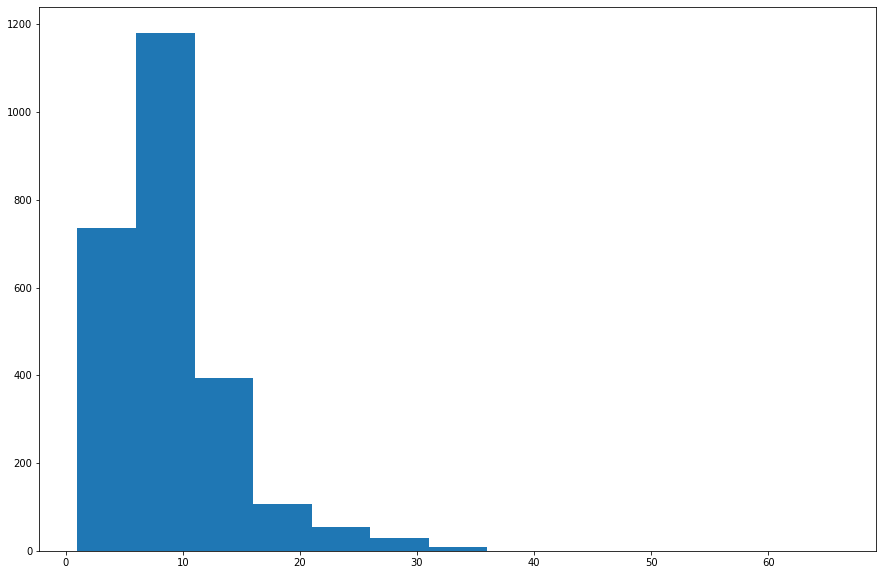

In [33]:
totalNumWords = [len(one_comment) for one_comment in sequences]
plt.figure(figsize=(15, 10))
plt.hist(totalNumWords, bins=[i for i in range(1,70, 5)])
plt.show()

Here we can see that there is not any post's title having length more than 50.

In [35]:
# Padding
MAX_LEN = 50
padded_sequences = pad_sequences(sequences, maxlen=MAX_LEN)

In [36]:
padded_sequences

array([[   0,    0,    0, ...,    0,  260, 1696],
       [   0,    0,    0, ...,  262,  581,  407],
       [   0,    0,    0, ...,   10, 1699,  482],
       ...,
       [   0,    0,    0, ...,   77,   15, 2259],
       [   0,    0,    0, ...,  190,   20,   52],
       [   0,    0,    0, ...,  477,  130,  100]], dtype=int32)

Initializing the pretrained word embeddings of FastText Crawl by Facebook for ***Transfer Learning***.

In [39]:
embedding_path = '/kaggle/input/fasttext-crawl-300d-2m/crawl-300d-2M.vec'

In NLP tasks Embeding Layer would be the first hidden layer of the model.<br>
Keras offers an Embedding layer that can be used for neural networks on text data. It requires that the input data be integer encoded, so that each word is represented by a unique integer. <br>
The Embedding layer is initialized with random weights and will learn an embedding for all of the words in the training dataset.<br>
A word embedding is an approaches for representing words and documents using a dense vector representation.<br>
Here I am not lettting the Embedding Layer to initialize it's random weights. I am using a ***TRANSFER LEARNING*** approach to train the model.

The FastText Carwl word embedding that I downloaded from Kaggle are pre-trained word embeddings trained and released by Facebook after training on 2 million words. The size of embedding is 4GB.

Pretrained Word Embeddings are the embeddings learned in one task that are used for solving another similar task.

This FastText crawl embedding is trained on large datasets, saved, and then I am using it for solving other tasks. That’s why pretrained word embeddings are a form of **Transfer Learning**.<br>
Transfer learning, as the name suggests, is about transferring the learnings of one task to another. 

This Embedding is 300-dimnesional.

Setting embedding size & max number of features in next code cell.

In [41]:
embed_size = 300
max_features = 30000

Here I am preparing the Embedding Matrix for the model by the FastText embedding.

In [42]:
import numpy as np
def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')

embedding_index = dict(get_coefs(*o.strip().split(" ")) for o in open(embedding_path))

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.zeros((nb_words + 1, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None: 
        
        # Words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [44]:
embedding_matrix.shape

(6955, 300)

Now I am going to encode output column(flair) using One Hot Encoding. This is where the words like ASKINDIA, AMA etc is removed and a new binary variable is added for each unique value.

In [45]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)
y_ohe = ohe.fit_transform(posts['flair'].values.reshape(-1, 1))

In [46]:
y_ohe

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

These are all the categories in the dataset

In [47]:
ohe.categories_

[array(['AMA', 'AskIndia', 'Business/Finance', 'Food', 'Non-Political',
        'Photography', 'Policy/Economy', 'Politics', 'Scheduled',
        'Science/Technology', 'Sports'], dtype=object)]

Saving the ohe object for further usage in other files.

In [48]:
import pickle

# saving
with open('encoder.pickle', 'wb') as handle:
    pickle.dump(ohe, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Lets start building the model

Initializing the file path for best model and Checkpoint to save the model whenever the validation accuarcy improves.

In [49]:
file_path = "best_model.hdf5"
check_point = ModelCheckpoint(file_path, monitor = "val_accuracy", verbose = 1,
                              save_best_only = True, mode = "max")

Defining an early stop with patience=25, that means if the validation accuracy didn't improved in last 25 epochs that model will stop training.

In [50]:
early_stop = EarlyStopping(monitor = "val_accuracy", mode = "max", patience = 25)

check_point and early_stop are be known as model callbacks.

Creating a function build_model that contains all the layers of our non-sequential fully connected Deep Learning model.

In [54]:
def build_model(lr = 0.0, lr_d = 0.0, units = 0, dr = 0.0):
    inp = Input(shape = (50,))
    x = Embedding(embedding_matrix.shape[0], embed_size, weights = [embedding_matrix], trainable = False)(inp)
    x1 = SpatialDropout1D(dr)(x)
    global history
    x_gru = Bidirectional(GRU(units, return_sequences = True))(x1)
    x1 = Conv1D(32, kernel_size=3, padding='valid', kernel_initializer='he_uniform')(x_gru)
    avg_pool1_gru = GlobalAveragePooling1D()(x1)
    max_pool1_gru = GlobalMaxPooling1D()(x1)
    
    x3 = Conv1D(32, kernel_size=2, padding='valid', kernel_initializer='he_uniform')(x_gru)
    avg_pool3_gru = GlobalAveragePooling1D()(x3)
    max_pool3_gru = GlobalMaxPooling1D()(x3)
    
    x_lstm = Bidirectional(LSTM(units, return_sequences = True))(x1)
    x1 = Conv1D(32, kernel_size=3, padding='valid', kernel_initializer='he_uniform')(x_lstm)
    avg_pool1_lstm = GlobalAveragePooling1D()(x1)
    max_pool1_lstm = GlobalMaxPooling1D()(x1)
    
    x3 = Conv1D(32, kernel_size=2, padding='valid', kernel_initializer='he_uniform')(x_lstm)
    avg_pool3_lstm = GlobalAveragePooling1D()(x3)
    max_pool3_lstm = GlobalMaxPooling1D()(x3)
    
    
    x = concatenate([avg_pool1_gru, max_pool1_gru, avg_pool3_gru, max_pool3_gru,
                    avg_pool1_lstm, max_pool1_lstm, avg_pool3_lstm, max_pool3_lstm])
    x = BatchNormalization()(x)
    x = Dropout(0.2)(Dense(128,activation='relu') (x))
    x = BatchNormalization()(x)
    x = Dropout(0.2)(Dense(100,activation='relu') (x))
    x = Dense(11, activation = "sigmoid")(x)
    
    model = Model(inputs = inp, outputs = x)
    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr = lr, decay = lr_d), metrics = ["accuracy"])
    history = model.fit(padded_sequences, y_ohe, batch_size = 128, epochs = 200, validation_split=0.3, 
                        verbose = 1, callbacks = [check_point, early_stop])
    model = load_model(file_path)
    import matplotlib.pyplot as plt
    print(history.history.keys())
   
    
    return model

I am using both GRU and LSTM layers in the model. GRU use less training parameters and therefore use less memory, execute faster and train faster than LSTM's whereas LSTM is more accurate on dataset using longer sequence. Both layers can be helpful in the NLP related task.

For Validation I am splitting 30% of data. That means model will train on 1534 samples, validate on 658 samples

In [55]:
model = build_model(lr = 1e-4, lr_d = 0, units = 128, dr = 0.5)

Train on 1757 samples, validate on 753 samples
Epoch 1/200
1757/1757 [==============================] - 11s 6ms/step - loss: 0.8466 - accuracy: 0.4754 - val_loss: 0.6818 - val_accuracy: 0.6306

Epoch 00001: val_accuracy improved from -inf to 0.63057, saving model to best_model.hdf5
Epoch 2/200
1757/1757 [==============================] - 3s 2ms/step - loss: 0.7878 - accuracy: 0.5146 - val_loss: 0.6756 - val_accuracy: 0.6627

Epoch 00002: val_accuracy improved from 0.63057 to 0.66268, saving model to best_model.hdf5
Epoch 3/200
1757/1757 [==============================] - 3s 2ms/step - loss: 0.7257 - accuracy: 0.5617 - val_loss: 0.6669 - val_accuracy: 0.6924

Epoch 00003: val_accuracy improved from 0.66268 to 0.69238, saving model to best_model.hdf5
Epoch 4/200
1757/1757 [==============================] - 3s 2ms/step - loss: 0.6851 - accuracy: 0.5961 - val_loss: 0.6548 - val_accuracy: 0.7305

Epoch 00004: val_accuracy improved from 0.69238 to 0.73053, saving model to best_model.hdf5
Epo

1757/1757 [==============================] - 3s 2ms/step - loss: 0.2809 - accuracy: 0.9102 - val_loss: 0.2572 - val_accuracy: 0.9171

Epoch 00036: val_accuracy improved from 0.91609 to 0.91706, saving model to best_model.hdf5
Epoch 37/200
1757/1757 [==============================] - 3s 2ms/step - loss: 0.2774 - accuracy: 0.9101 - val_loss: 0.2532 - val_accuracy: 0.9180

Epoch 00037: val_accuracy improved from 0.91706 to 0.91802, saving model to best_model.hdf5
Epoch 38/200
1757/1757 [==============================] - 3s 2ms/step - loss: 0.2767 - accuracy: 0.9100 - val_loss: 0.2499 - val_accuracy: 0.9189

Epoch 00038: val_accuracy improved from 0.91802 to 0.91887, saving model to best_model.hdf5
Epoch 39/200
1757/1757 [==============================] - 3s 2ms/step - loss: 0.2718 - accuracy: 0.9128 - val_loss: 0.2464 - val_accuracy: 0.9198

Epoch 00039: val_accuracy improved from 0.91887 to 0.91984, saving model to best_model.hdf5
Epoch 40/200
1757/1757 [==============================] -

1757/1757 [==============================] - 3s 2ms/step - loss: 0.2031 - accuracy: 0.9330 - val_loss: 0.1973 - val_accuracy: 0.9373

Epoch 00072: val_accuracy improved from 0.93650 to 0.93734, saving model to best_model.hdf5
Epoch 73/200
1757/1757 [==============================] - 3s 2ms/step - loss: 0.2034 - accuracy: 0.9329 - val_loss: 0.1952 - val_accuracy: 0.9376

Epoch 00073: val_accuracy improved from 0.93734 to 0.93758, saving model to best_model.hdf5
Epoch 74/200
1757/1757 [==============================] - 3s 2ms/step - loss: 0.2026 - accuracy: 0.9332 - val_loss: 0.1953 - val_accuracy: 0.9376

Epoch 00074: val_accuracy improved from 0.93758 to 0.93758, saving model to best_model.hdf5
Epoch 75/200
1757/1757 [==============================] - 3s 2ms/step - loss: 0.1980 - accuracy: 0.9348 - val_loss: 0.1952 - val_accuracy: 0.9379

Epoch 00075: val_accuracy improved from 0.93758 to 0.93795, saving model to best_model.hdf5
Epoch 76/200
1757/1757 [==============================] -

1757/1757 [==============================] - 3s 2ms/step - loss: 0.1641 - accuracy: 0.9438 - val_loss: 0.1857 - val_accuracy: 0.9396

Epoch 00109: val_accuracy did not improve from 0.94169
Epoch 110/200
1757/1757 [==============================] - 4s 2ms/step - loss: 0.1629 - accuracy: 0.9445 - val_loss: 0.1856 - val_accuracy: 0.9401

Epoch 00110: val_accuracy did not improve from 0.94169
Epoch 111/200
1757/1757 [==============================] - 3s 2ms/step - loss: 0.1586 - accuracy: 0.9449 - val_loss: 0.1855 - val_accuracy: 0.9405

Epoch 00111: val_accuracy did not improve from 0.94169
Epoch 112/200
1757/1757 [==============================] - 3s 2ms/step - loss: 0.1617 - accuracy: 0.9443 - val_loss: 0.1860 - val_accuracy: 0.9401

Epoch 00112: val_accuracy did not improve from 0.94169
Epoch 113/200
1757/1757 [==============================] - 3s 2ms/step - loss: 0.1659 - accuracy: 0.9432 - val_loss: 0.1848 - val_accuracy: 0.9408

Epoch 00113: val_accuracy did not improve from 0.94169

Vizualizing the loss and accuracy or training and validation in each epoch.

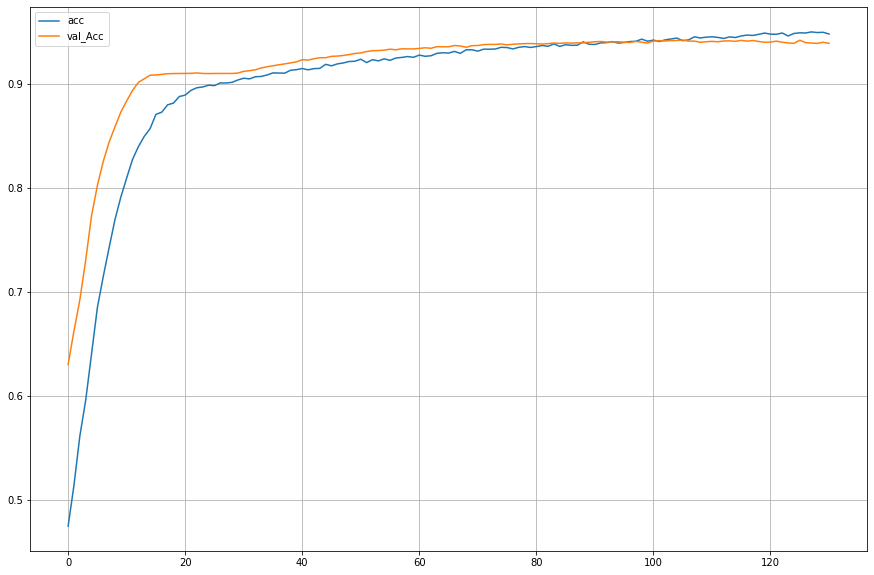

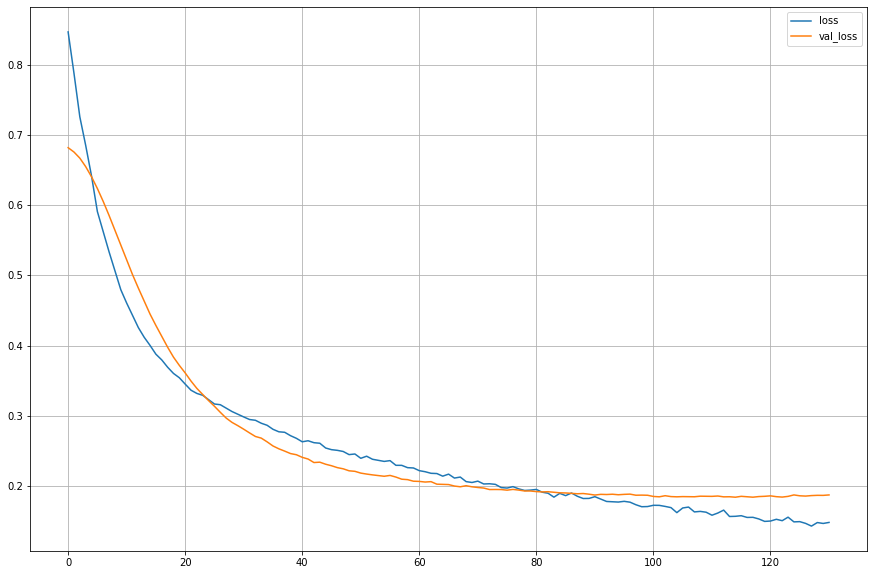

In [56]:
plt.figure(figsize=(15, 10))
plt.plot(history.history['accuracy'], label="acc")
plt.plot(history.history['val_accuracy'], label="val_Acc")
plt.grid()
plt.legend()
plt.show()
plt.figure(figsize=(15, 10))
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.grid()
plt.legend()
plt.show()

Plotting the model to show all the layers and flow of my Neural Network.

### The final validation accracy is 94.2% and validation loss is 0.16

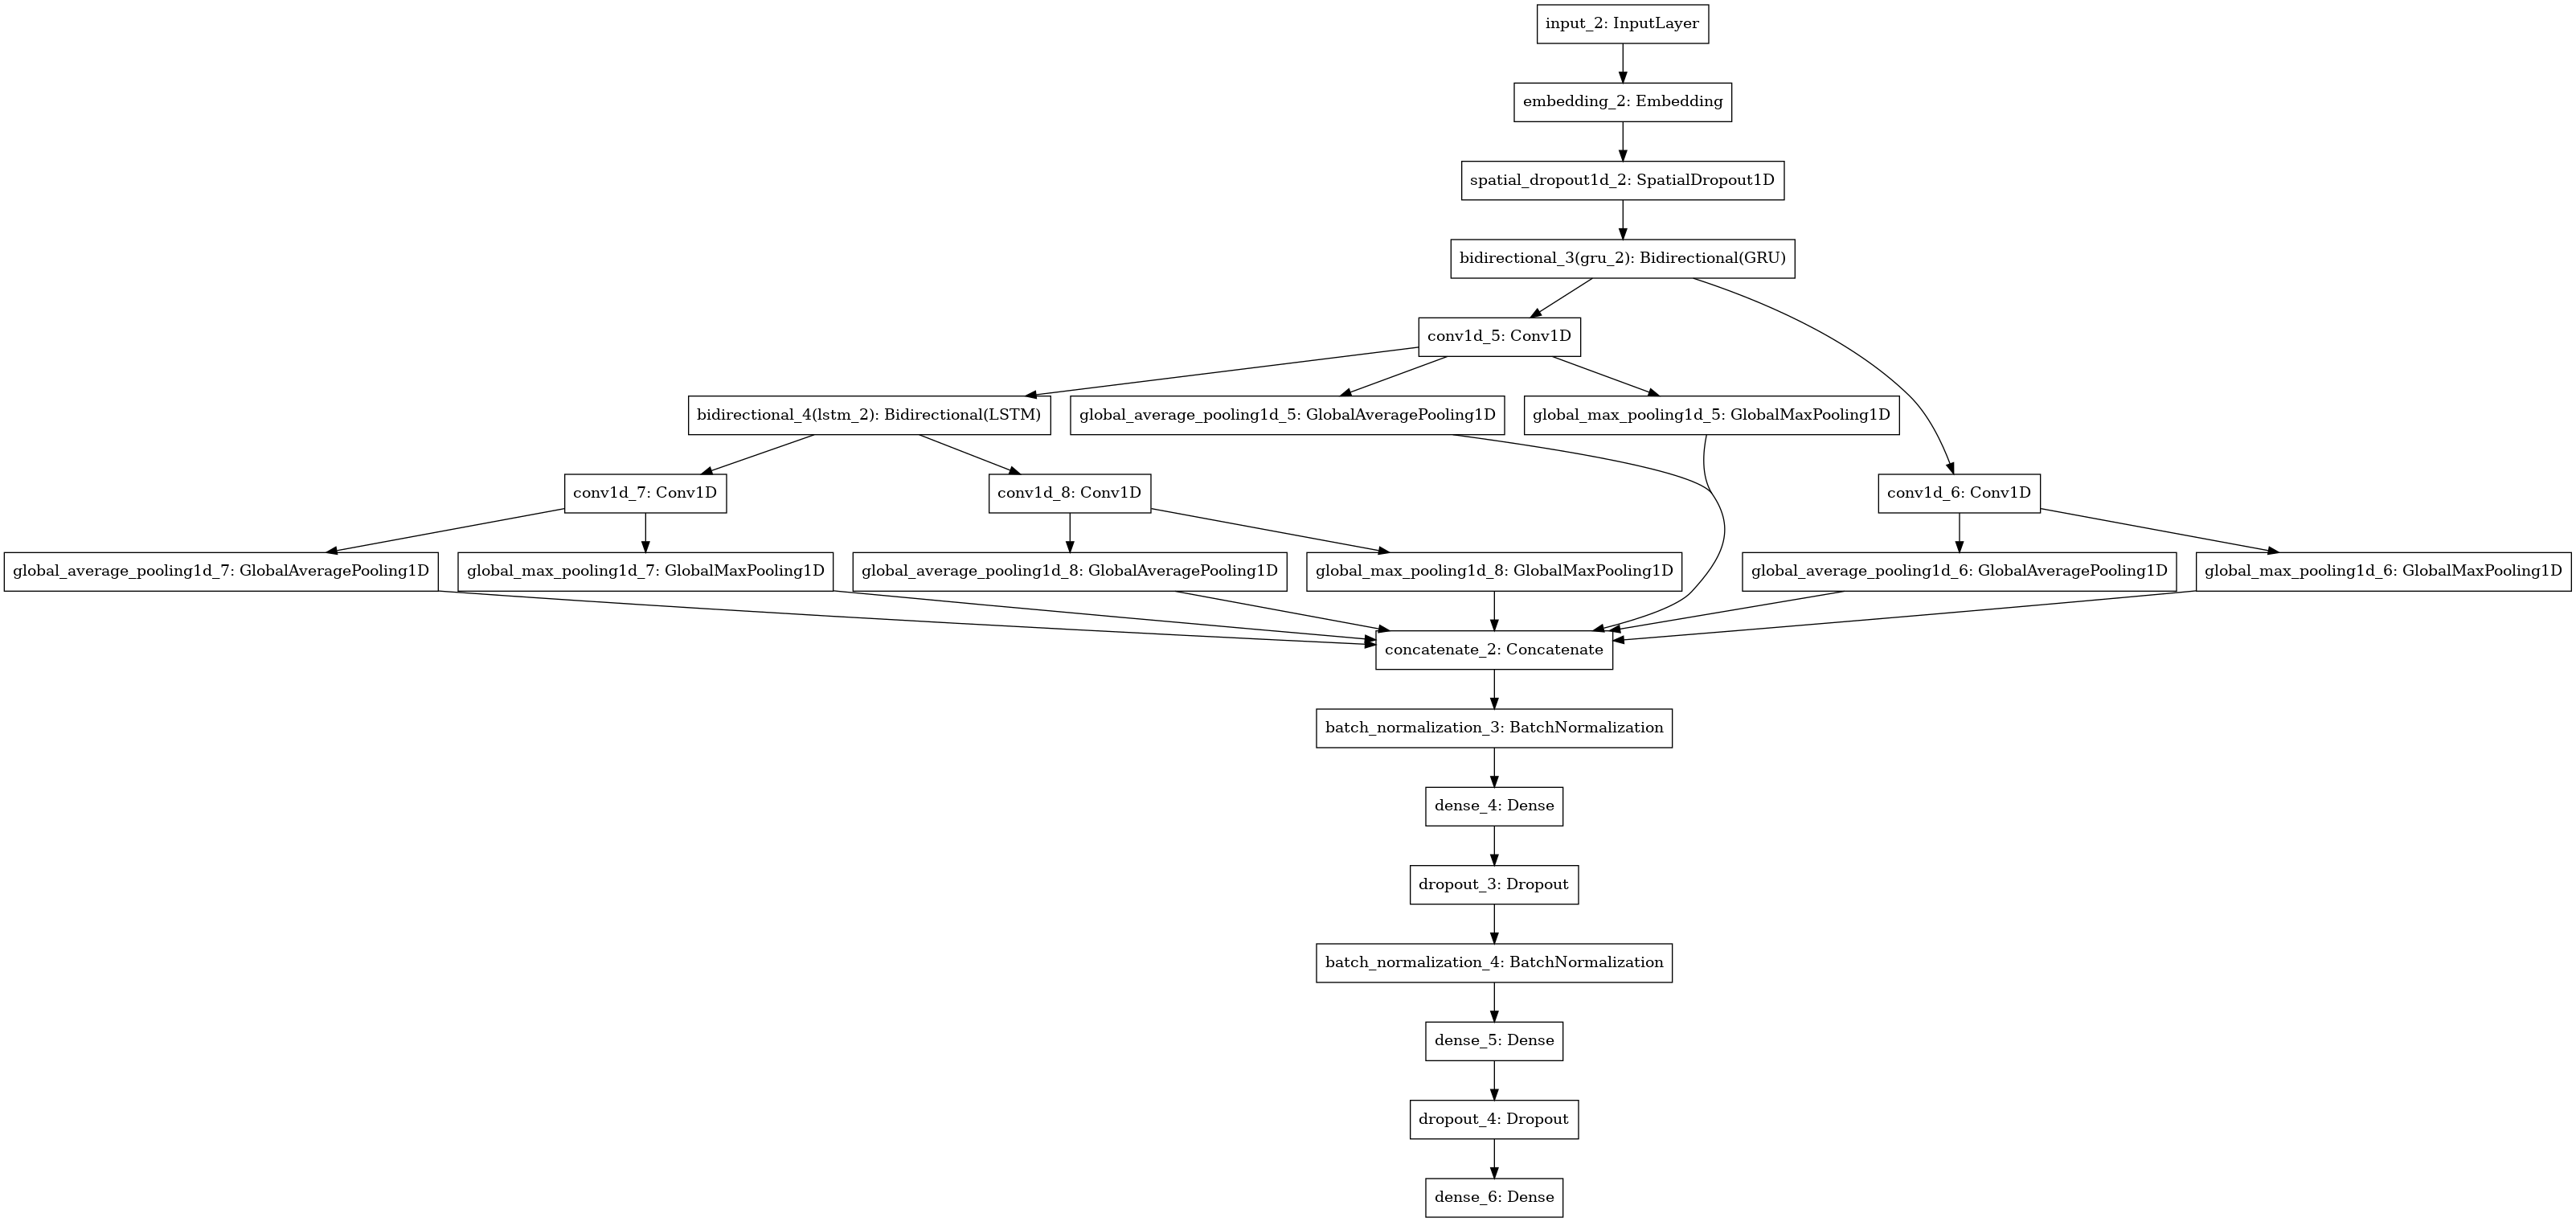

In [57]:
plot_model(model, to_file='./model.png')

In [58]:
def remove_noise_test(x):
  text = [" ".join(x.lower() for x in x[0].split())]
  text = [" ".join(x.strip() for x in text[0].split())]
  text = [" ".join(x for x in text[0].split() if x not in stop)]
  text = [re.sub(r"\[.*?\]", "", text[0])]
  text = [re.sub('[^a-zA-Z0-9\s]', '', text[0])]
  lm=WordNetLemmatizer()
  text = [lm.lemmatize(text[0])]
  text = tokenizer.texts_to_sequences(x)
  text = pad_sequences(text, maxlen=50, dtype='int32', value=0)
  return text

Here I am copying some real Reddit posts and cross checking the flair.

In [59]:
x = ["State Visit of Prime Minister Gandhi of India. President Reagan's Speech and Prime Minister Gandhi's Speech at Arrival Ceremony, South Lawn on July 29, 1982"]

text = remove_noise_test(x)

ans = model.predict(text, batch_size=1, verbose=2)

ohe.categories_[0][ans[0].argmax()]

'Politics'

In [60]:
x = ["Holy river Ganges self-cleared during lockdown. This was shot at Triveni Ghat, Rishikesh, Uttarakhand."]

text = remove_noise_test(x)

ans = model.predict(text, batch_size=1, verbose=2)

ohe.categories_[0][ans[0].argmax()]

'Photography'